In [5]:
import torch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(dev)

cuda:0


In [6]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose(
    [
        # transforms.Resize(size=(227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6900, 0.4713, 0.5236], std=[0.3172, 0.4550, 0.4746]),
        # transforms.Normalize(mean=[0.5685, 0.2570, 0.4582], std=[0.3371, 0.3743, 0.4563]),
    ]
)

train_data_path = 'DataSets/mitbih_fusion_227/train/'
test_data_path = 'DataSets/mitbih_fusion_227/test/'

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)
train_data = torch.utils.data.DataLoader(dir_train,batch_size=128,shuffle=True,num_workers=8)

dir_test = torchvision.datasets.ImageFolder(test_data_path,transform=transform)
test_data = torch.utils.data.DataLoader(dir_test,batch_size=32,shuffle=True,num_workers=8)

len(train_data.dataset)

87554

In [7]:
# imgs = torch.stack([i for img,_ in test_data for i in img], dim=3)
# media = imgs.view(3,-1).mean(dim=1)
# desvio = imgs.view(3,-1).std(dim=1)
# print(media,desvio)

In [8]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()
        loss.backward()
        Optimizer.step()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [9]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = len(val_data.dataset)
    
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [10]:
from torch import nn
import torchvision.models as models

cnn = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
for i,param in enumerate(cnn.parameters()):
    if i >= 5: break
    param.requires_grad=False
num_ftrs = cnn.classifier[6].out_features
cnn.classifier.add_module("7",nn.Linear(num_ftrs, 5))
cnn.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-3,momentum=0.9)

In [12]:
epochs = 20
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
loss_best_model = 1e9

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(cnn,loss_function,optimizer,train_data)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(cnn,loss_function,test_data)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < loss_best_model:
        loss_best_model = val_loss_per_epoch
        model_path = 'SavedModels/test_model'
        torch.save(cnn.state_dict(),model_path)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 0.2870397604730007
Val Loss: 0.18125042962930063
Train Accuracy: 0.923704206943512
Val Accuracy: 0.950301468372345

Starting epoch 2
Train Loss: 0.17456417985287678
Val Loss: 0.14753107546291647
Train Accuracy: 0.9514813423156738
Val Accuracy: 0.9603964686393738

Starting epoch 3
Train Loss: 0.1401151827896816
Val Loss: 0.12176043840845789
Train Accuracy: 0.9613609910011292
Val Accuracy: 0.9670655727386475

Starting epoch 4
Train Loss: 0.1224756577857736
Val Loss: 0.11171232482255267
Train Accuracy: 0.9661923050880432
Val Accuracy: 0.9693495035171509

Starting epoch 5
Train Loss: 0.10801316191353937
Val Loss: 0.10758501508946183
Train Accuracy: 0.9702126383781433
Val Accuracy: 0.9713137149810791

Starting epoch 6
Train Loss: 0.09939703623879782
Val Loss: 0.10005720584911641
Train Accuracy: 0.9721543192863464
Val Accuracy: 0.9725927114486694

Starting epoch 7
Train Loss: 0.09250072466658198
Val Loss: 0.09742696218559668
Train Accuracy: 0.973970353603363
Val 

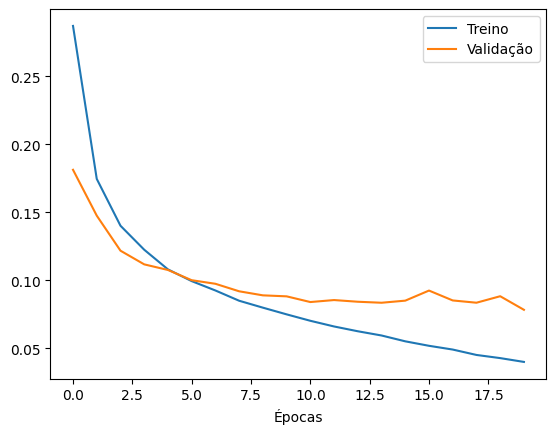

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

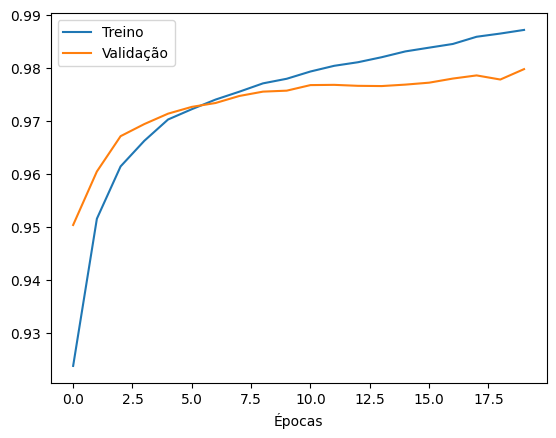

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [15]:
from sklearn.metrics import classification_report

cnn.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1,digits=5))

              precision    recall  f1-score   support

         0.0    0.98401   0.99514   0.98954     18118
         1.0    0.91885   0.69245   0.78974       556
         2.0    0.94892   0.93646   0.94265      1448
         3.0    0.81343   0.67284   0.73649       162
         4.0    0.98803   0.97512   0.98153      1608

    accuracy                        0.97972     21892
   macro avg    0.93065   0.85440   0.88799     21892
weighted avg    0.97907   0.97972   0.97891     21892



In [23]:
import torch
import torchvision.models as models

saved_model = models.alexnet()
num_ftrs = saved_model.classifier[6].out_features
saved_model.classifier.add_module("7",nn.Linear(num_ftrs, 5))

saved_model.load_state_dict(torch.load('SavedModels/best_model'))

saved_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
from sklearn.metrics import classification_report

saved_model.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = saved_model(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1,digits=5))

              precision    recall  f1-score   support

         0.0    0.98401   0.99514   0.98954     18118
         1.0    0.91885   0.69245   0.78974       556
         2.0    0.94892   0.93646   0.94265      1448
         3.0    0.81343   0.67284   0.73649       162
         4.0    0.98803   0.97512   0.98153      1608

    accuracy                        0.97972     21892
   macro avg    0.93065   0.85440   0.88799     21892
weighted avg    0.97907   0.97972   0.97891     21892

